# Neural Network

In [1]:
# Import the required libraries and dependencies
import pandas as pd
import numpy as np
import math
import matplotlib
import seaborn as sns
from pathlib import Path
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib inline

## Using a Single Neuron for Binary Classification

### Step 1 - Import Stock and Social Media data

In [2]:
# Import stock data from .csv file
CEI_data = Path("../Resources/CEI_data.csv")
CEI_df = pd.read_csv(CEI_data, delimiter=",")
CEI_df.head()

,time,open,high,low,close,volume
0,2021-08-02 09:00:00-04:00,0.4576,0.4576,0.4566,0.4566,200
1,2021-08-02 09:15:00-04:00,0.4548,0.4548,0.4546,0.4546,200
2,2021-08-02 09:30:00-04:00,0.4514,0.4514,0.4498,0.4498,200
3,2021-08-02 09:45:00-04:00,0.4484,0.4498,0.4484,0.4498,200
4,2021-08-02 10:15:00-04:00,0.4470,0.4470,0.4470,0.4470,387


In [3]:
# Format the date/time value
CEI_df['time'] = CEI_df['time'].str.slice(0, 16)
CEI_df

,time,open,high,low,close,volume
0,2021-08-02 09:00,0.4576,0.4576,0.4566,0.4566,200
1,2021-08-02 09:15,0.4548,0.4548,0.4546,0.4546,200
2,2021-08-02 09:30,0.4514,0.4514,0.4498,0.4498,200
3,2021-08-02 09:45,0.4484,0.4498,0.4484,0.4498,200
4,2021-08-02 10:15,0.4470,0.4470,0.4470,0.4470,387
...,...,...,...,...,...,...
993,2021-10-01 13:00,3.1350,3.1850,3.1000,3.1750,11114
994,2021-10-01 13:15,3.1600,3.1600,3.1100,3.1250,15240
995,2021-10-01 13:30,3.1150,3.1350,3.0550,3.1150,21425
996,2021-10-01 13:45,3.1250,3.2000,3.1250,3.1600,18138


In [4]:
# Import social media data from .csv file
SM_df = pd.read_csv(
    Path("../reddit_resources/reddit_data.csv"), 
    delimiter=",",
    index_col = "date",
    parse_dates =True,
    infer_datetime_format =True
    )

SM_df

,title,selftext,score,num_comments
date,,,,
2021-10-02 01:43:23+00:00,"I have no DD. It’s a cheap price, the stock ha...",NaN,1,0
2021-10-02 01:08:40+00:00,Who is in PED? It is an energy stock! I am in ...,\nToday it had a run. It is an energy stock. H...,1,0
2021-10-01 20:45:15+00:00,"WHO IS KNOWN FOR CARBON CAPTURE,OH YES. $CEI",NaN,1,0
2021-10-01 19:21:32+00:00,$PROG - The Next Big Short Squeeze Candidate,"Alright retards, I can't believe I happened up...",1,0
2021-10-01 18:26:46+00:00,CEI 100% PORT YOLO GAIN HODL TILL 10$+ then 20$,NaN,1,0
...,...,...,...,...
2018-09-24 21:10:24+00:00,CEI too the moon,100%+ returns today what do you guys think?\n\...,1,0
2018-02-28 20:04:11+00:00,The cheapest thing on Robinhood currently is [...,[removed],21,37
2017-11-22 16:34:32+00:00,BUY CEI U WILL 9X TIMES INCREASE UR MONEY$$$ h...,[removed],1,0


In [5]:
# Rounding time to next 15 minutes interval
SM_df['time'] = SM_df.index.round(freq='15T').astype(str)
SM_df['time'] = SM_df['time'].str.slice(0, 16)
SM_df.head()

,title,selftext,score,num_comments,time
date,,,,,
2021-10-02 01:43:23+00:00,"I have no DD. It’s a cheap price, the stock ha...",NaN,1,0,2021-10-02 01:45
2021-10-02 01:08:40+00:00,Who is in PED? It is an energy stock! I am in ...,\nToday it had a run. It is an energy stock. H...,1,0,2021-10-02 01:15
2021-10-01 20:45:15+00:00,"WHO IS KNOWN FOR CARBON CAPTURE,OH YES. $CEI",NaN,1,0,2021-10-01 20:45
2021-10-01 19:21:32+00:00,$PROG - The Next Big Short Squeeze Candidate,"Alright retards, I can't believe I happened up...",1,0,2021-10-01 19:15
2021-10-01 18:26:46+00:00,CEI 100% PORT YOLO GAIN HODL TILL 10$+ then 20$,NaN,1,0,2021-10-01 18:30


In [6]:
# Group the thread and count / sum value
grouped_df = SM_df.groupby('time') 
NewSM_df = grouped_df[['score', 'num_comments']].agg('sum')
NewSM_df['total_thread'] = grouped_df.size()
NewSM_df

,score,num_comments,total_thread
time,,,
2017-10-06 13:00,7,13,1
2017-11-21 07:00,1,0,1
2017-11-22 16:30,1,0,1
2018-02-28 20:00,21,37,1
2018-09-24 21:15,1,0,1
...,...,...,...
2021-10-01 18:30,1,0,1
2021-10-01 19:15,1,0,1
2021-10-01 20:45,1,0,1


Text(0.5, 1.0, 'Reddit Thread Count')

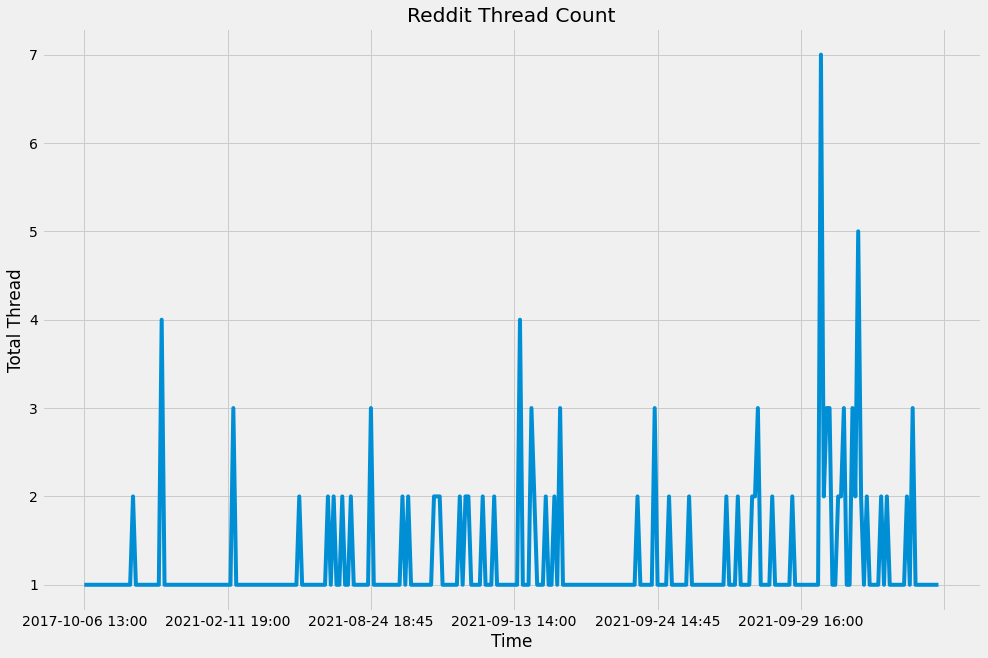

In [7]:
# Evalulate frequency of Reddit Thread each day
matplotlib.style.use('fivethirtyeight')
NewSM_df['total_thread'].plot(figsize=(15, 10))
plt.xlabel("Time")
plt.ylabel("Total Thread") 
plt.title("Reddit Thread Count")

In [8]:
# Merge stock and social media dataframe
df = pd.merge(CEI_df, NewSM_df, how="left", on=['time'])
df = df.fillna(0)
df

,time,open,high,low,close,volume,score,num_comments,total_thread
0,2021-08-02 09:00,0.4576,0.4576,0.4566,0.4566,200,0.0,0.0,0.0
1,2021-08-02 09:15,0.4548,0.4548,0.4546,0.4546,200,0.0,0.0,0.0
2,2021-08-02 09:30,0.4514,0.4514,0.4498,0.4498,200,0.0,0.0,0.0
3,2021-08-02 09:45,0.4484,0.4498,0.4484,0.4498,200,0.0,0.0,0.0
4,2021-08-02 10:15,0.4470,0.4470,0.4470,0.4470,387,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
993,2021-10-01 13:00,3.1350,3.1850,3.1000,3.1750,11114,0.0,0.0,0.0
994,2021-10-01 13:15,3.1600,3.1600,3.1100,3.1250,15240,0.0,0.0,0.0
995,2021-10-01 13:30,3.1150,3.1350,3.0550,3.1150,21425,0.0,0.0,0.0
996,2021-10-01 13:45,3.1250,3.2000,3.1250,3.1600,18138,0.0,0.0,0.0


Text(0.5, 1.0, 'Close Price vs. Total Thread')

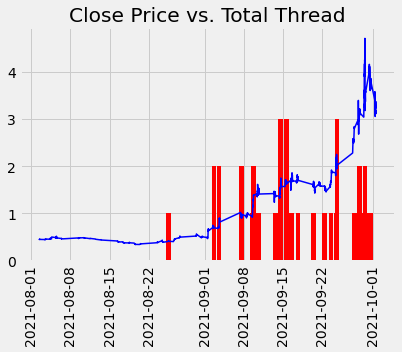

In [9]:
x = df['time'].astype('datetime64[ns]')
y = df['close']
z = df['total_thread']
plt.plot(x, y, color="Blue", linewidth=1.5)
plt.bar(x, z, color="Red")
plt.xticks(rotation=90)
plt.title("Close Price vs. Total Thread")

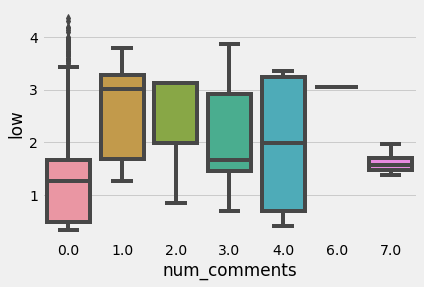

In [10]:
sns.boxplot(x=df['num_comments'],y=df['low'],data=df)
plt.show()

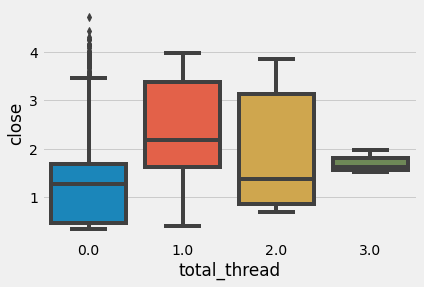

In [11]:
sns.boxplot(x=df['total_thread'],y=df['close'],data=df)
plt.show()

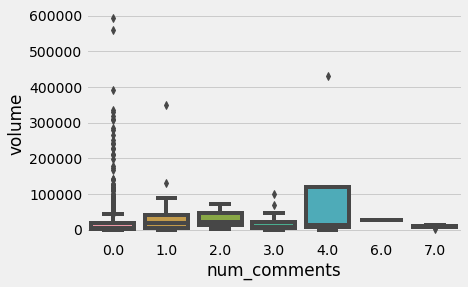

In [12]:
sns.boxplot(x=df['num_comments'],y=df['volume'],data=df)
plt.show()

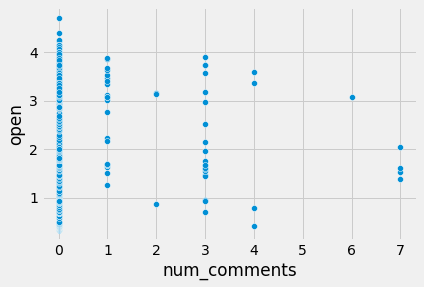

In [13]:
sns.scatterplot(x=df['num_comments'],y=df['open'],data=df)
plt.show()

In [14]:
df = df.drop(columns='volume')

### Step 2 - Encoded Data

In [15]:
# Split target column from dataset
y = df['close']
X = df.drop(columns='close')

# Set Index
X = X.set_index('time')

# Binary encoding using Pandas (multiple columns) for Social Media Data
X = pd.get_dummies(X)

X.tail()

,open,high,low,score,num_comments,total_thread
time,,,,,,
2021-10-01 13:00,3.135,3.185,3.100,0.0,0.0,0.0
2021-10-01 13:15,3.160,3.160,3.110,0.0,0.0,0.0
2021-10-01 13:30,3.115,3.135,3.055,0.0,0.0,0.0
2021-10-01 13:45,3.125,3.200,3.125,0.0,0.0,0.0
2021-10-01 14:00,3.170,3.215,3.100,0.0,0.0,0.0


### Step 3 - Scaling Data

In [16]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Creating the scaler instance
scaler = StandardScaler()

# Fitting the scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4 - Neural Network Model Creation

#### Add the layers of Neural Network

In [55]:
# Create a sequential model
neuron = Sequential()

# First layer of Neural Network
number_inputs = 6
number_hidden_nodes = 2

neuron.add(Dense(units=number_hidden_nodes, activation="tanh", input_dim=number_inputs))

# Create the second hidden layer
# number_hidden_nodes2 = 2

# neuron.add(Dense(units=number_hidden_nodes2, activation="relu"))

# Output layer
output_nodes = 1

neuron.add(Dense(units=output_nodes, activation="tanh"))

# Model summary
neuron.summary()

## Compile model
## neuron.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Compile the model 
# Set the parameters as mean_squared_error, adam, and mse.
neuron.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 2)                 14        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Fit the model
# The validation split parameter splits the data into testing and training sets.
model = neuron.fit(X, y, validation_split=0.1, epochs=800, verbose=0)

#### Evaluate the Model

<AxesSubplot:>

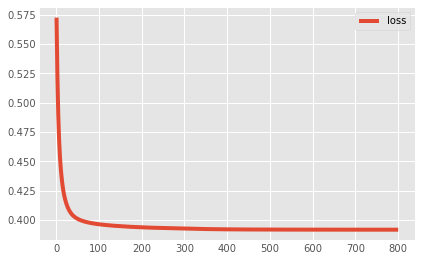

In [57]:
# Plotting the Loss Function and Accuracy
# Create a DataFrame with the history dictionary
df = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

# Plot the loss
df.plot(y="loss")

In [58]:
# Evaluate the model using the testing data
model_loss, model_accuracy = neuron.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 2.8200 - mse: 2.8200
Loss: 2.819951057434082, Accuracy: 2.819951057434082


### Step 5 - Prediction

In [59]:
# Making predictions
predictions = neuron.predict(X_test_scaled)
results = pd.DataFrame({"predictions": predictions.ravel(), "actual": y_test.ravel()})
results.head(10)

,predictions,actual
0,-0.789773,0.7310
1,0.999996,1.6300
2,0.108680,1.8200
3,0.999996,4.1200
4,-0.913456,0.3912
5,0.999995,3.6600
6,-0.899596,0.4510
7,-0.635945,0.9232
8,-0.885957,0.4911
9,-0.885656,0.4919


Text(0.5, 1.0, 'Stock Price Prediction')

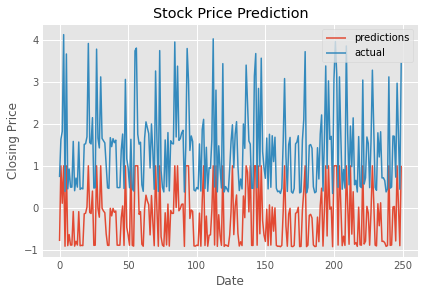

In [60]:
# Plot the CEI stock closing price Actual vs. Prediction
matplotlib.style.use('ggplot')
results.plot(linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Prediction")